In [1]:
# Set up plot stuff the DFM way:

%run ../document/figures/plot_setup.py

In [2]:
# Get target list; this follows the selection in ../document/figures/targets.py 
import sys
sys.path.append('..')

from peerless.catalogs import KICatalog, KOICatalog, EBCatalog, BlacklistCatalog
import numpy as np
import pandas as pd

stlr = KICatalog().df
m = (4200 <= stlr.teff) & (stlr.teff <= 6100)
m &= stlr.radius <= 1.15
m &= stlr.dataspan > 365.25*2.
m &= stlr.dutycycle > 0.6
m &= stlr.rrmscdpp07p5 <= 1000.
m &= stlr.kepmag < 15.

# known EBs
ebs = set(np.array(EBCatalog().df["#KIC"]))

# KOI false positives
kois = KOICatalog().df
kois = kois[kois.koi_disposition == "FALSE POSITIVE"]
fps = set(np.array(kois.kepid))

# And then finally the blacklist.
bl = set(np.array(BlacklistCatalog().df.kicid))

# The full list of ignores.
ignore = fps | bl #ebs | fps | bl  #Don't ignore EBs for purposes of prediction
m &= ~stlr.kepid.isin(ignore)

targets = stlr[m]

In [3]:
targets[['kepid','mass','feh']].count()

kepid    39626
mass     38983
feh      39626
dtype: int64

In [4]:
# funny, there seem to be some missing masses.  Let's artificially add those in, with M=R
bad = targets.mass.isnull()
targets.loc[bad, 'mass'] = targets.loc[bad, 'radius']

/u/tdm/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [5]:
from exosyspop import KeplerBinaryPopulation, TRILEGAL_BGBinaryPopulation

/u/tdm/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [6]:
ebpop = KeplerBinaryPopulation(targets, ecc_empirical=True)
bgstars = pd.read_hdf('bgstars.h5','df')
bgpop = TRILEGAL_BGBinaryPopulation(targets, bgstars, ecc_empirical=True)

EB: dmag regressor trained, R2=0.999512166935
EB: qR regressor trained, R2=0.999467814601


/u/tdm/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


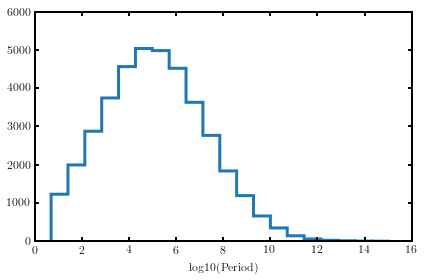

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(np.log10(ebpop.period), bins=20, histtype='step', lw=3);
plt.xlabel('log10(Period)');

In [8]:
ebpop.params

{'beta_a': 0.8,
 'beta_b': 2.0,
 'fB': 0.44,
 'gamma': 0.3,
 'mu_logp': 2.3979400086720375,
 'period_min': 5.0,
 'qmin': 0.1,
 'sig_logp': 2.3}

In [9]:
q = 'period > 20 and period < 1000 and ((n_pri > 0 and ' +\
    'n_sec > 0) or (n_pri > 2 or n_sec > 2)) and (T14_pri < 2.5 or T14_sec < 2.5)'
ebs = ebpop.observe(new=True).query(q)
bgs = bgpop.observe(new=True).query(q)
print('{} EBs'.format(len(ebs)))
print('{} BEBs'.format(len(bgs)))

BGEB: dmag regressor trained, R2=0.961960907614
BGEB: qR regressor trained, R2=0.826769870541
53 EBs
49 BEBs


OK, this is how many EBs we predict there to be with periods between 20 and 1000 days.  How does this compare with the actual EB catalog?

In [10]:
# Total number of Kepler EBs with 20 < P < 1000, scaled by number of targets
from __future__ import division
len(EBCatalog().df.query('period>20 and period < 1000')) * (len(targets)/len(KICatalog().df))

104.73989897725737

Let's do a bunch of these observation simulations and see what it looks like:

In [11]:
n_obs = [len(ebpop.observe(new=True).query(q)) for i in range(200)]

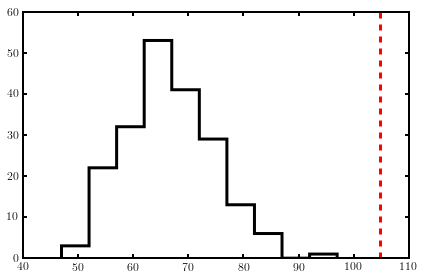

In [12]:
plt.hist(n_obs, histtype='step', lw=3, bins=10, color='k');
plt.axvline(104.74, color='r', ls='--', lw=3);

Now we want to know what's the typical number of single/double eclipse signals.

In [13]:
dfm_q = 'n_pri < 3 and n_sec < 3 and (n_pri==0 or n_sec==0)'
dfm_q += ' and ((T14_pri < 2.5 or n_pri==0) or (T14_sec < 2.5 or n_sec==0))'
nobs_eb = [len(ebpop.observe(new=True).query(dfm_q)) for i in range(200)]
nobs_bg = [len(bgpop.observe(new=True).query(dfm_q)) for i in range(200)]

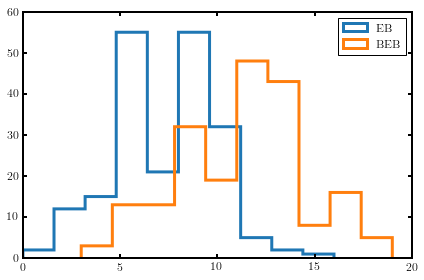

In [14]:
plt.hist(nobs_eb, histtype='step', lw=3, label='EB');
plt.hist(nobs_bg, histtype='step', lw=3, label='BEB');
plt.legend()

OK, now let's determine the typical shapes.  Let's do this with a big sample of simulated observations.  The secondary property/trapezoid shape regressions need some debugging for the background population, so let's just use isochrones and fit trapezoids directly.

In [16]:
#Be patient, this takes a few minutes...verbosity to keep you company.
N = 1000
#q = 'period > 20 and period < 1000 and (T14_pri < 2.5 or T14_sec < 2.5)'
eb_obs = ebpop.get_N_observed(query=dfm_q, N=N, fit_trap=True, regr_trap=False, 
                              use_ic=True, verbose=True)
bg_obs = bgpop.get_N_observed(query=dfm_q, N=N, fit_trap=True, regr_trap=False,
                              use_ic=True, verbose=True)

7
14
21
26
32
41
50
60
66
78
83
91
97
107
108
113
119
127
130
134
146
158
160
166
173
179
190
202
206
210
219
231
240
242
252
255
264
274
286
294
308
314
320
327
333
340
346
349
359
366
369
376
387
393
397
403
406
410
414
421
425
433
439
445
456
459
468
473
478
485
496
504
510
513
519
528
538
543
552
560
567
574
582
587
599
606
613
621
630
634
646
652
657
663
671
677
682
688
700
709
717
730
740
745
753
765
773
779
788
793
798
804
813
822
829
837
840
844
855
862
865
872
882
889
898
902
910
916
922
928
938
948
957
963
971
978
986
994
1001
3
7
10
17
21
26
33
39
41
44
49
57
59
65
71
74
79
84
90
97
102
108
110
112
116
123
130
139
143
148
152
159
163
169
175
181
184
191
198
200
205
207
211
216
219
225
226
229
233
236
239
247
254
256
260
264
269
271
276
279
282
284
292
297
301
309
311
317
322
325
326
332
338
344
349
351
359
367
369
376
377
381
385
391
395
399
406
408
413
415
420
423
425
432
439
446
450
455
461
462
463
467
469
477
481
487
498
501
507
511
513
517
523
530
538
542
546
553
561
564

In [26]:
from scipy.stats import gaussian_kde

def get_kde(df, max_duration=2.5):
    
    pri = df.n_pri > 0
    sec = df.n_sec > 0

    depth = (pri*df.trap_depth_pri + sec*df.trap_depth_sec) * df.dilution
    duration = pri*df.trap_dur_pri + sec*df.trap_dur_sec            
        
    ok = np.isfinite(np.log10(depth)) & (duration < max_duration)
    return gaussian_kde(np.array([duration[ok], np.log10(depth)[ok]]))

eb_kde = get_kde(eb_obs)
bg_kde = get_kde(bg_obs)

OK, now let's load up the candidates.

In [27]:
candidates = pd.read_csv('../results/candidates.csv').query('accept_bic and accept_time and num_peaks <= 2')
candidates[['depth','transit_duration']].head()

,depth,transit_duration
17,0.003340,0.393807
27,0.078353,1.157742
39,0.015872,0.684503
40,0.015061,0.684186
43,0.023301,0.361075


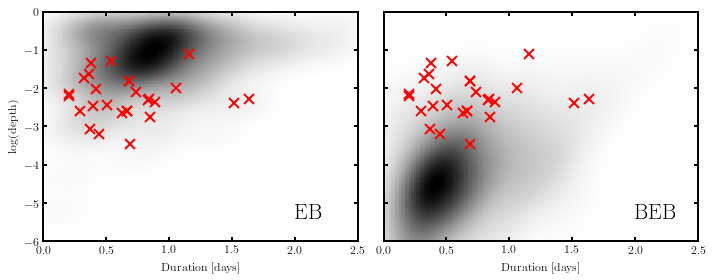

In [28]:
def plot_kde(kde, ax=None, dur_range=(0,2.5), depth_range=(-6,0), 
            cands=candidates, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(1,1)
        
    dur_grid = np.arange(dur_range[0], dur_range[1], 0.02)
    depth_grid = np.arange(depth_range[0], depth_range[1], 0.02)
    xx, yy = np.meshgrid(dur_grid, depth_grid)
    f = kde(np.vstack([xx.ravel(),yy.ravel()])).reshape(xx.shape)
    ax.imshow(f, origin='lower', extent=[dur_range[0], dur_range[1],
                                         depth_range[0], depth_range[1]], 
               aspect='auto', cmap='binary', **kwargs)
    ax.set_xlabel('Duration [days]')
    ax.set_ylabel('log(depth)')
    
    if cands is not None:
        ax.plot(cands.transit_duration, np.log10(cands.depth), 'rx', ms=10)
    
fig, axes = plt.subplots(1,2, figsize=(10,4), sharey=True)
plot_kde(eb_kde, ax=axes[0])
plot_kde(bg_kde, ax=axes[1])
axes[1].set_ylabel('')
plt.subplots_adjust(wspace=0)
for ax,title in zip(axes, ['EB','BEB']):
    ax.annotate(title, xy=(0.8,0.1), xycoords='axes fraction', fontsize=22)